<a href="https://colab.research.google.com/github/IyadSultan/AI_pediatric_oncology/blob/main/07_training_a_vision_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This notebook is a modificiaiton of Jacob Labur notebook but using pytorch

🩺 0 | Install & Imports

In [ ]:
# %%capture
!pip install -q opendatasets torch torchvision torcheval scikit-learn tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 17.3 MB/s eta 0:00:00


In [ ]:
import opendatasets as od, pathlib, os, time, json, math
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import (roc_curve, auc, precision_recall_curve,
                             average_precision_score, confusion_matrix,
                             ConfusionMatrixDisplay, accuracy_score,
                             precision_score, recall_score)
print("PyTorch:", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


PyTorch: 2.5.1+cu124


| Piece | Reason |
|-------|--------|
| **torch / torchvision** | Core DL + ready-made MobileNetV2 |
| **torcheval** | (optional) more metrics |
| **scikit-learn** | ROC, PR, confusion-matrix |
| `device`        | auto-GPU switch |

1 | Download Chest-Xray-Pneumonia Dataset

In [ ]:
url = "https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia"
od.download(url, force=True)           # prompts for Kaggle creds if not set
root = pathlib.Path("chest-xray-pneumonia/chest_xray")
train_dir, val_dir, test_dir = [root/p for p in ["train", "val", "test"]]
print("Data ready at:", root)


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: iyadsultan
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia


100%|██████████| 2.29G/2.29G [01:47<00:00, 22.9MB/s]



Data ready at: chest-xray-pneumonia/chest_xray


2 | Transforms & DataLoaders
Key idea: Resize to
128
×
128
128×128, apply random augments only on training, convert to tensor & normalize using ImageNet mean/std (MobileNetV2 was pre-trained there).

In [ ]:
IMG_SIZE = 128
BATCH     = 32

imgnet_mean = (0.485, 0.456, 0.406)
imgnet_std  = (0.229, 0.224, 0.225)

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.9,1.1)),
    transforms.ToTensor(),
    transforms.Normalize(imgnet_mean, imgnet_std),
])

val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(imgnet_mean, imgnet_std),
])

train_ds = datasets.ImageFolder(train_dir, transform=train_tfms)
val_ds   = datasets.ImageFolder(val_dir,   transform=val_tfms)
test_ds  = datasets.ImageFolder(test_dir,  transform=val_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

class_names = train_ds.classes        # ['NORMAL', 'PNEUMONIA']
print("Classes:", class_names)



Classes: ['NORMAL', 'PNEUMONIA']


3 | Peek at a Few Images (optional)
python
Copy
Edit


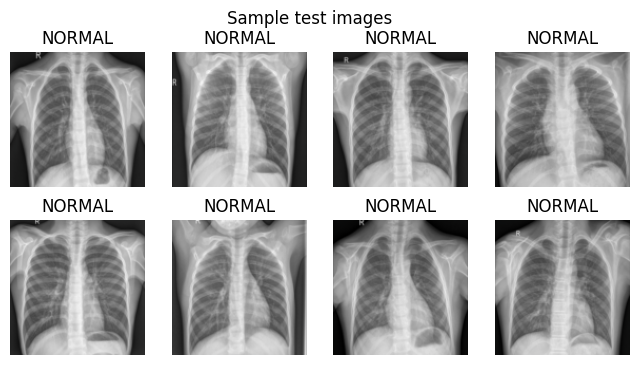

In [ ]:
def imshow(inp, title=None):
    inp = inp.cpu().numpy().transpose((1,2,0))*np.array(imgnet_std)+np.array(imgnet_mean)
    plt.imshow(np.clip(inp,0,1)); plt.axis('off');
    if title: plt.title(title)

batch = next(iter(test_loader))
plt.figure(figsize=(8,4))
for i,(img,label) in enumerate(zip(*batch)):
    if i==8: break
    plt.subplot(2,4,i+1)
    imshow(img); plt.title(class_names[label])
plt.suptitle("Sample test images"); plt.show()


4 | Build Transfer-Learning Model

In [ ]:
base = models.mobilenet_v2(weights="IMAGENET1K_V1")
base.classifier = nn.Sequential(             # replace head
    nn.Dropout(0.2),
    nn.Linear(base.last_channel, 1)          # binary → 1 logit
)
model = base.to(device)

# Freeze feature extractor for phase-1
for p in base.features.parameters():
    p.requires_grad_(False)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 190MB/s]


5 | Train Head (Phase-1)

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

def train_one_epoch(loader):
    model.train(); running=0
    for X,y in loader:
        X,y = X.to(device), y.float().to(device).unsqueeze(1)
        optimizer.zero_grad()
        loss = criterion(model(X), y)
        loss.backward(); optimizer.step()
        running += loss.item()*X.size(0)
    return running/len(loader.dataset)

def eval_loss(loader):
    model.eval(); running=0
    with torch.no_grad():
        for X,y in loader:
            X,y = X.to(device), y.float().to(device).unsqueeze(1)
            running += criterion(model(X), y).item()*X.size(0)
    return running/len(loader.dataset)

EPOCHS1 = 3
for epoch in range(EPOCHS1):
    t0=time.time()
    train_loss = train_one_epoch(train_loader)
    val_loss   = eval_loss(val_loader)
    print(f"Epoch {epoch+1}/{EPOCHS1}  train {train_loss:.4f}  val {val_loss:.4f}  ({time.time()-t0:.1f}s)")


Epoch 1/3  train 0.3082  val 0.6952  (68.9s)
Epoch 2/3  train 0.2185  val 0.9466  (67.4s)
Epoch 3/3  train 0.1927  val 0.8209  (66.7s)


6 | Un-freeze Top Layers (Phase-2 Fine-Tune)

In [ ]:
for layer in base.features[14:]:             # unfreeze last ~1/3
    for p in layer.parameters():
        p.requires_grad_(True)

optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

EPOCHS2 = 5
for epoch in range(EPOCHS1, EPOCHS1+EPOCHS2):
    t0=time.time()
    train_loss = train_one_epoch(train_loader)
    val_loss   = eval_loss(val_loader)
    print(f"Epoch {epoch+1}/{EPOCHS1+EPOCHS2}  train {train_loss:.4f}  val {val_loss:.4f}  ({time.time()-t0:.1f}s)")


Epoch 4/8  train 0.1458  val 0.6893  (68.4s)
Epoch 5/8  train 0.1131  val 0.3093  (67.1s)
Epoch 6/8  train 0.0915  val 1.1461  (67.0s)
Epoch 7/8  train 0.0796  val 0.2098  (67.0s)
Epoch 8/8  train 0.0760  val 0.2283  (67.5s)


7 | Evaluate on Test Set

In [ ]:
def get_preds(loader):
    model.eval(); probs, y_true = [], []
    with torch.no_grad():
        for X,y in loader:
            X = X.to(device)
            logits = model(X).flatten()
            probs.extend(torch.sigmoid(logits).cpu().numpy())
            y_true.extend(y.numpy())
    return np.array(probs), np.array(y_true)

probs, y_true = get_preds(test_loader)
y_pred = (probs>=0.5).astype(int)


metrics + plots

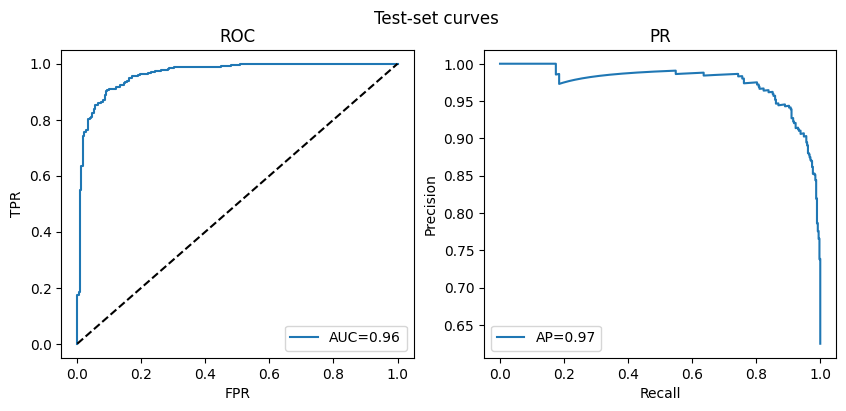

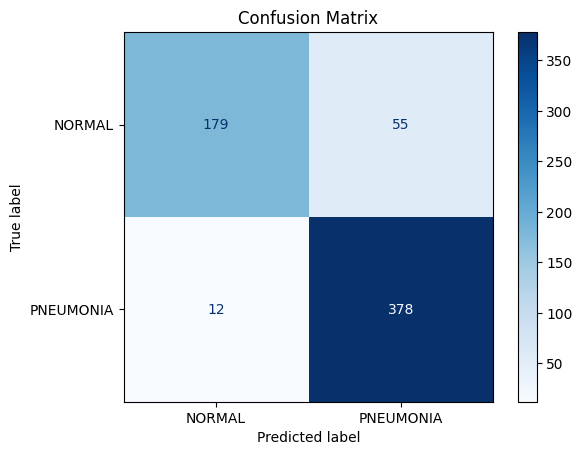

Accuracy : 0.8926
Precision: 0.8730
Recall   : 0.9692


In [ ]:
def plot_roc_pr(y_true, probs, title):
    fpr, tpr, _ = roc_curve(y_true, probs)
    roc_auc = auc(fpr, tpr)
    prec, rec, _ = precision_recall_curve(y_true, probs)
    ap = average_precision_score(y_true, probs)
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].plot(fpr, tpr, label=f"AUC={roc_auc:.2f}"); ax[0].plot([0, 1], [0, 1], 'k--')
    ax[0].set(xlabel='FPR', ylabel='TPR', title='ROC'); ax[0].legend()
    ax[1].plot(rec, prec, label=f"AP={ap:.2f}")
    ax[1].set(xlabel='Recall', ylabel='Precision', title='PR'); ax[1].legend()
    plt.suptitle(title); plt.show()

plot_roc_pr(y_true, probs, "Test-set curves")

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=class_names).plot(cmap='Blues')
plt.title("Confusion Matrix"); plt.show()

print("Accuracy : {:.4f}".format(accuracy_score(y_true, y_pred)))
print("Precision: {:.4f}".format(precision_score(y_true, y_pred)))
print("Recall   : {:.4f}".format(recall_score(y_true, y_pred)))

8 | Educational Takeaways
Topic	Key lesson
Transfer-learning	Freeze → train head → un-freeze top layers with small LR for a big accuracy jump.
Data augmentation	Random flips/rotations add invariance (but never on validation/test).
BCEWithLogitsLoss	Combines sigmoid + BCE → stable, no need for explicit sigmoid in model.
Evaluation beyond accuracy	ROC, PR, confusion matrix reveal imbalanced-class pitfalls.
Threshold tuning	0.5 is default; in medicine you might pick threshold for target sensitivity (recall).
GPU vs CPU	device switching is trivial; bigger images/models may need torch.cuda.amp mixed precision.
Reproducibility	Low epochs in demo; dial up for real training. Seed random libs (torch.manual_seed).

 Next Steps
Swap MobileNetV2 for EfficientNet_B0 (torchvision.models.efficientnet_b0) for a minor accuracy boost.

Add learning-rate scheduler (torch.optim.lr_scheduler.CosineAnnealingLR).

Push metrics to Weights & Biases or TensorBoard for live tracking.

Export to TorchServe or ONNX for deployment in clinical image viewer apps.